### Оцифровка дыхания
#### В данном ноутбуке реализуется оцифровка дыхания (из волны или спектрограммы в буквы)

In [2]:
import warnings
import time
import os
import sys

warnings.simplefilter(action='ignore')

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import librosa
import sklearn
from scipy.spatial.distance import euclidean
from scipy.signal import correlate
import hashlib

Сравнение волн

In [3]:
def load_audio(file_path):
    # Load the audio file
    signal, sr = librosa.load(file_path, sr=None)
    return signal, sr

def compare_waveforms(signal1, signal2):
    # Normalize signals
    signal1 = signal1 / np.max(np.abs(signal1))
    signal2 = signal2 / np.max(np.abs(signal2))
    # Compute cross-correlation
    correlation = correlate(signal1, signal2, mode='full')
    max_corr = np.max(correlation)
    return max_corr

def compare_mfcc(file1, file2):
    # Extract MFCC features
    signal1, sr1 = load_audio(file1)
    signal2, sr2 = load_audio(file2)
    mfcc1 = librosa.feature.mfcc(y=signal1, sr=sr1, n_mfcc=13)
    mfcc2 = librosa.feature.mfcc(y=signal2, sr=sr2, n_mfcc=13)

    # Use Dynamic Time Warping (DTW) to measure similarity
    distance, _, _, _ = dtw(mfcc1.T, mfcc2.T, dist_method=euclidean)
    return distance

Сравнение спектрограмм и хэширование

In [4]:
def compute_spectrogram_hash(audio_file):
    # Load the audio file with its original sampling rate.
    y, sr = librosa.load(audio_file, sr=None)
    
    # Compute the short-time Fourier transform (STFT) to get the spectrogram.
    # The magnitude (absolute value) is used to represent the intensity.
    S = np.abs(librosa.stft(y))
    
    # Normalize the spectrogram to the range [0, 1]
    S_norm = (S - S.min()) / (S.max() - S.min())
    
    # Quantize the normalized spectrogram to 8-bit integers (0-255)
    S_quantized = (S_norm * 255).astype(np.uint8)
    
    # Convert the quantized spectrogram into bytes
    spectrogram_bytes = S_quantized.tobytes()
    
    # Create a SHA256 hash of the spectrogram bytes
    hash_obj = hashlib.sha256(spectrogram_bytes)
    hash_value = hash_obj.hexdigest()
    
    return hash_value

In [5]:

def hex_to_bin(hex_string):
    """
    Convert a hexadecimal string into a binary string,
    ensuring that leading zeros are preserved.
    """
    num_bits = len(hex_string) * 4  # each hex digit is 4 bits
    return bin(int(hex_string, 16))[2:].zfill(num_bits)

def compute_similarity(hash1, hash2):
    """
    Compute the similarity between two hex hash strings by comparing
    their binary representations. Returns a percentage of identical bits.
    """
    # Convert hex strings to binary strings
    bin1 = hex_to_bin(hash1)
    bin2 = hex_to_bin(hash2)

    if len(bin1) != len(bin2):
        raise ValueError("Hashes must be of the same length for comparison.")

    # Calculate the number of identical bits
    identical_bits = sum(b1 == b2 for b1, b2 in zip(bin1, bin2))
    total_bits = len(bin1)
    
    # Compute similarity percentage
    similarity_percentage = (identical_bits / total_bits) * 100
    return similarity_percentage



Audio fingerprinting

In [6]:
from scipy.ndimage import maximum_filter
from math import exp, sqrt


def compute_spectrogram(audio_file):
    """
    Load an audio file and compute its STFT magnitude spectrogram.
    The spectrogram is converted to dB scale.
    """
    y, sr = librosa.load(audio_file, sr=None)
    S = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    return S_db, sr

def extract_peaks(S_db, amp_min=-40, neighborhood_size=(20, 20)):
    """
    Identify local spectral peaks in the dB-scaled spectrogram.
    Only peaks above the amp_min threshold are retained.
    """
    local_max = maximum_filter(S_db, size=neighborhood_size) == S_db
    detected_peaks = np.where(local_max & (S_db >= amp_min))
    peaks = list(zip(detected_peaks[0], detected_peaks[1]))
    return peaks

def generate_features_from_peaks(peaks, fan_value=5, delta_time_max=10):
    """
    Instead of generating discrete hash strings, generate numerical fingerprint
    features. Each feature is a tuple: (freq1, freq2, time_delta)
    where freq1 and freq2 are frequency bins of paired peaks and time_delta is their time difference.
    """
    peaks.sort(key=lambda x: x[1])  # sort by time
    features = []
    num_peaks = len(peaks)
    
    for i in range(num_peaks):
        freq1, time1 = peaks[i]
        for j in range(1, fan_value + 1):
            if i + j < num_peaks:
                freq2, time2 = peaks[i + j]
                time_delta = time2 - time1
                if 0 < time_delta <= delta_time_max:
                    features.append((freq1, freq2, time_delta))
    return features

def extract_audio_fingerprint(audio_file):
    """
    Extract continuous fingerprint features from an audio file.
    Returns a list of tuples (freq1, freq2, time_delta)
    """
    S_db, sr = compute_spectrogram(audio_file)
    peaks = extract_peaks(S_db, amp_min=-40, neighborhood_size=(20, 20))
    features = generate_features_from_peaks(peaks, fan_value=5, delta_time_max=10)
    return features

def feature_distance(feat1, feat2):
    """
    Compute Euclidean distance between two fingerprint features.
    Each feature is a tuple (freq1, freq2, time_delta).
    """
    return sqrt(sum((a - b) ** 2 for a, b in zip(feat1, feat2)))

def gaussian_similarity(distance, sigma=10.0):
    """
    Convert a distance to a similarity score using a Gaussian kernel.
    The score is in the range (0, 1], where 0 means no similarity and 1 means perfect match.
    """
    return exp(- (distance ** 2) / (2 * sigma ** 2))

def compute_continuous_similarity(fp_features1, fp_features2, sigma=10.0):
    """
    Compute a continuous similarity score between two sets of fingerprint features.
    
    For each feature in the first fingerprint, find the closest feature in the second fingerprint
    (using Euclidean distance), convert that distance into a similarity score via a Gaussian kernel,
    and average these scores. Repeat symmetrically and then average both directions.
    """
    if not fp_features1 or not fp_features2:
        return 0.0

    def avg_similarity(features_A, features_B):
        total_sim = 0.0
        for feat_A in features_A:
            # Find the minimum distance to any feature in features_B
            min_dist = min(feature_distance(feat_A, feat_B) for feat_B in features_B)
            total_sim += gaussian_similarity(min_dist, sigma=sigma)
        return total_sim / len(features_A)
    
    sim1 = avg_similarity(fp_features1, fp_features2)
    sim2 = avg_similarity(fp_features2, fp_features1)
    # Average the two directional similarities
    return (sim1 + sim2) / 2

In [7]:
data_path = '../letters_source_files/'

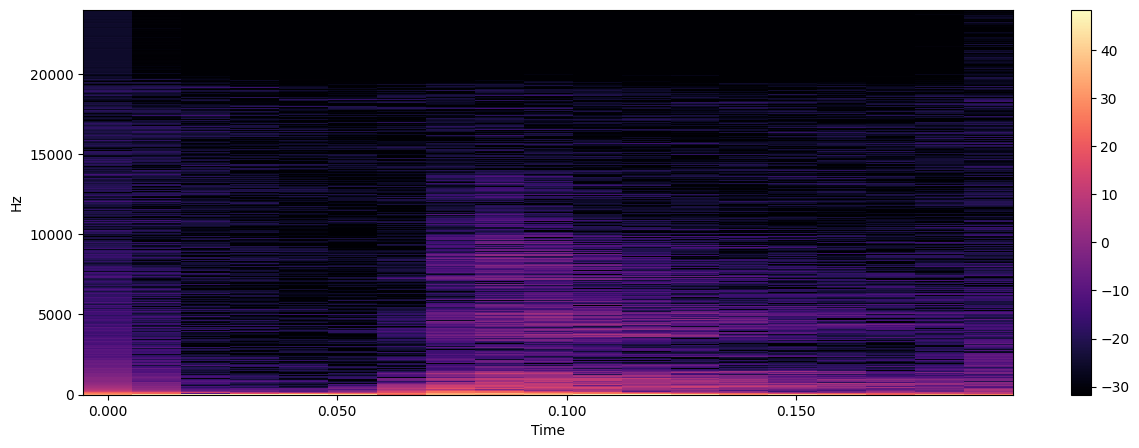

In [10]:
%matplotlib inline

x , sr = load_audio(data_path + 'т.wav')
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar()

In [52]:
file1 = "modified_letters/х.wav"
file2 = "modified_letters/х.wav"

# Load audio
signal1, sr1 = load_audio(file1)
signal2, sr2 = load_audio(file2)

# Waveform similarity
waveform_similarity = compare_waveforms(signal1, signal2)
print(f"Waveform Similarity (Max Correlation): {waveform_similarity}")

# MFCC similarity
# mfcc_distance = compare_mfcc(file1, file2)
# print(f"MFCC Distance: {mfcc_distance}")

Waveform Similarity (Max Correlation): 1087.932861328125


In [97]:
from pydub import AudioSegment
import glob
import random

work_directory = "modified_data/"
breath_files = glob.glob(work_directory + "*.wav")
letters = glob.glob("letters_source_files/*.wav")

for b in random.sample(breath_files, 10):
    breath_audio, sr = load_audio(b)
    duration = librosa.get_duration(y=breath_audio, sr=sr) * 1000
    breath = AudioSegment.from_wav(b)

    print(b + ":", end=' ')
    for x in range(0, int(duration), 200):
        breath_fragment = breath[x:x+200]
        temp_output = "temp_fragment.wav"
        breath_fragment.export(temp_output, format='wav')

        # comparing
        best_similarity = {}
        breath_fragment_for_comparing, sr1 = load_audio(temp_output)
        for letter in letters:
            # print(letter)
            current_letter, sr2 = load_audio(letter)
            waveform_similarity = compare_waveforms(breath_fragment_for_comparing, current_letter)
            best_similarity[letter[15]] = float(waveform_similarity)
        print(max(best_similarity, key=best_similarity.get), end='')
    print("")

os.remove(temp_output)


modified_data/exhale_53.wav: ффттфффф
modified_data/inhale_33.wav: хфффттффтффффф
modified_data/inhale_31.wav: ффтффтфтфффс
modified_data/inhale_9.wav: ффттффтффффффттф
modified_data/exhale_22.wav: фффффффффттттфф
modified_data/exhale_25.wav: фффффффффффт
modified_data/exhale_49.wav: ффттфтфффттт
modified_data/exhale_88.wav: фтфттффффф
modified_data/exhale_16.wav: нфффффффффтффф
modified_data/inhale_55.wav: ффффтфффф


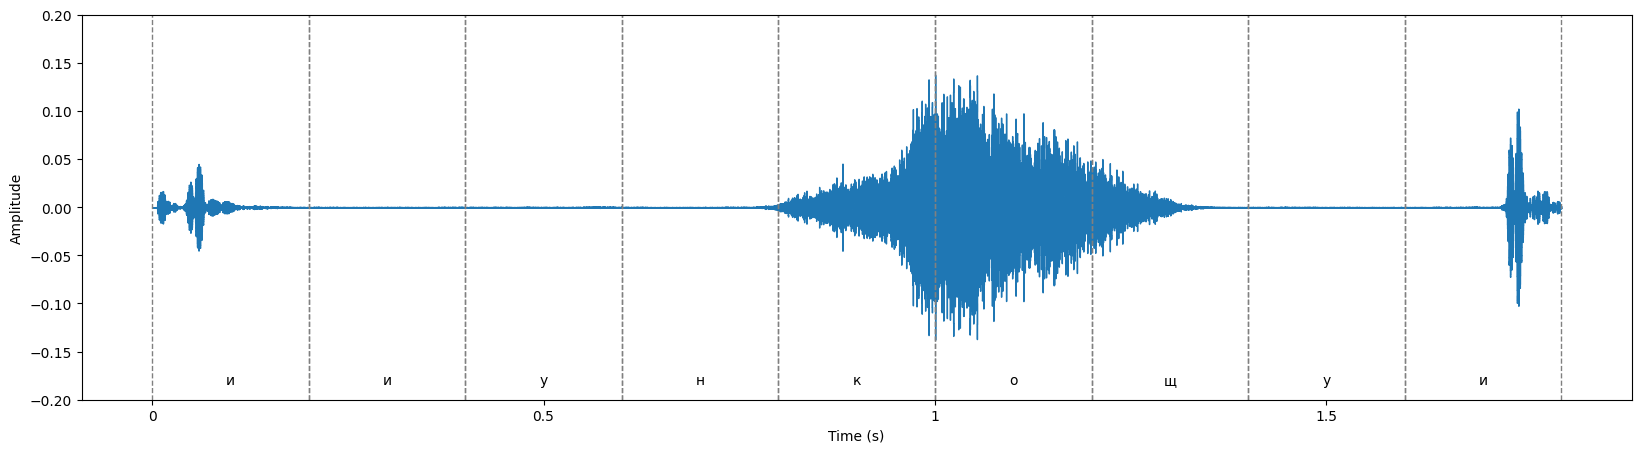

In [109]:
import string


data_path = "web_recordings/z/z_inhale_1.wav"
x , sr = librosa.load(data_path)

plt.figure(figsize=(20, 5))
translate = 'ииункощуи'

librosa.display.waveshow(x, sr=sr)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
duration = librosa.get_duration(y=x, sr=sr)
time_points = np.arange(0.1, duration, 0.2)

letters = list(translate)

# Add letters under the x-axis
for t, letter in zip(time_points, letters):
    plt.text(t, -0.18, letter, ha='center', va='center', fontsize=10, transform=plt.gca().transData)
    plt.axvline(x=t-0.1, color='gray', linestyle='--', linewidth=1)  # Vertical line at time 't-0.1'
    plt.axvline(x=t+0.1, color='gray', linestyle='--', linewidth=1)  # Vertical line at time 't+0.1'


# Adjust the limits and show the plot
plt.ylim(-0.2, 0.2)  # Adjust the y-axis to avoid overlap
plt.show()

Хэширование и сравнение

In [ ]:
file1 = data_path + "х.wav"
file2 = data_path + "ф.wav"

# Load audio
file1_hash = compute_spectrogram_hash(file1)
file2_hash = compute_spectrogram_hash(file2)

# Spectrogram similarity
hash_similarity = compute_similarity(file1_hash, file2_hash)
print(f"Hash Similarity: {hash_similarity}")


Hash Similarity: 51.953125


In [32]:
import glob
import random
from pydub import AudioSegment

work_directory = "../web_recordings/Sitting/audio/"
breath_files = glob.glob(work_directory + "*.wav")
letters = glob.glob("../letters_source_files/*.wav")

for b in random.sample(breath_files, 10):
    breath_audio, sr = load_audio(b)
    duration = librosa.get_duration(y=breath_audio, sr=sr) * 1000
    breath = AudioSegment.from_wav(b)

    print(b + ":", end=' ')
    for x in range(0, int(duration), 200):
        breath_fragment = breath[x:x+200]
        temp_output = "temp_fragment.wav"
        breath_fragment.export(temp_output, format='wav')

        # comparing
        best_similarity = {}
        breath_hash = compute_spectrogram_hash(temp_output)
        for letter in letters:
            # print(letter)
            letter_hash = compute_spectrogram_hash(letter)
            hash_similarity = compute_similarity(breath_hash, letter_hash)
            best_similarity[letter[24]] = float(hash_similarity)
        print(max(best_similarity, key=best_similarity.get), end='')
    print("")

os.remove(temp_output)


../web_recordings/Sitting/audio/Sitting_exhale_7.wav: ыпсцудзмогпзрм
../web_recordings/Sitting/audio/Sitting_inhale_10.wav: мупвссыугрглвзр
../web_recordings/Sitting/audio/Sitting_inhale_6.wav: щсфчааувпзкву
../web_recordings/Sitting/audio/Sitting_inhale_4.wav: влфзчлкшунчдоф
../web_recordings/Sitting/audio/Sitting_inhale_9.wav: фгмжбчмгонза
../web_recordings/Sitting/audio/Sitting_exhale_10.wav: гчкбтсзртодсы
../web_recordings/Sitting/audio/Sitting_exhale_6.wav: ипмоиргжчсрдзза
../web_recordings/Sitting/audio/Sitting_inhale_5.wav: кафзмбамсрибц
../web_recordings/Sitting/audio/Sitting_exhale_8.wav: учжжитзмвывс
../web_recordings/Sitting/audio/Sitting_inhale_8.wav: шжнуцомцуычн


Audio fingerprinting

In [60]:
file1 = data_path + "а.wav"
file2 = data_path + "п.wav"

# Load audio
file1_fingerprint = extract_audio_fingerprint(file1)
file2_fingerprint = extract_audio_fingerprint(file2)

# Fingerprint similarity
fingerprint_similarity = compute_continuous_similarity(file1_fingerprint, file2_fingerprint)
print(f"Fingerprint Similarity: {fingerprint_similarity}")


Fingerprint Similarity: 0.0


In [8]:
import glob
import random
from pydub import AudioSegment

work_directory = "../web_recordings/Sitting/audio/"
breath_files = glob.glob(work_directory + "*.wav")
letters = glob.glob("../letters_source_files/*.wav")

for b in random.sample(breath_files, 10):
    breath_audio, sr = load_audio(b)
    duration = librosa.get_duration(y=breath_audio, sr=sr) * 1000
    breath = AudioSegment.from_wav(b)

    print(b + ":", end=' ')
    for x in range(0, int(duration), 200):
        breath_fragment = breath[x:x+200]
        temp_output = "temp_fragment.wav"
        breath_fragment.export(temp_output, format='wav')

        # comparing
        best_similarity = {}
        breath_hash = extract_audio_fingerprint(temp_output)
        for letter in letters:
            # print(letter)
            letter_hash = extract_audio_fingerprint(letter)
            print(letter_hash)
            hash_similarity = compute_continuous_similarity(breath_hash, letter_hash)
            best_similarity[letter[24]] = float(hash_similarity)
        print(max(best_similarity, key=best_similarity.get), end='')
    print("")

os.remove(temp_output)

../web_recordings/Sitting/audio/Sitting_inhale_8.wav: [(np.int64(378), np.int64(160), np.int64(1)), (np.int64(378), np.int64(322), np.int64(1)), (np.int64(378), np.int64(334), np.int64(1)), (np.int64(406), np.int64(160), np.int64(1)), (np.int64(406), np.int64(322), np.int64(1)), (np.int64(406), np.int64(334), np.int64(1)), (np.int64(406), np.int64(175), np.int64(2)), (np.int64(445), np.int64(160), np.int64(1)), (np.int64(445), np.int64(322), np.int64(1)), (np.int64(445), np.int64(334), np.int64(1)), (np.int64(445), np.int64(175), np.int64(2)), (np.int64(445), np.int64(246), np.int64(2)), (np.int64(160), np.int64(175), np.int64(1)), (np.int64(160), np.int64(246), np.int64(1)), (np.int64(160), np.int64(0), np.int64(2)), (np.int64(322), np.int64(175), np.int64(1)), (np.int64(322), np.int64(246), np.int64(1)), (np.int64(322), np.int64(0), np.int64(2)), (np.int64(322), np.int64(41), np.int64(2)), (np.int64(334), np.int64(175), np.int64(1)), (np.int64(334), np.int64(246), np.int64(1)), (np.i

Сохраним отпечатки букв в один файл

In [66]:
letters = glob.glob("../letters_source_files/*.wav")
fingerprints = pd.DataFrame(columns=['letter', 'fingerprint'])
for letter in letters:
    # print(letter)
    letter_hash = extract_audio_fingerprint(letter)
    fingerprints.loc[len(fingerprints)] = {'letter': letter[24], 'fingerprint': letter_hash}
fingerprints.to_csv("fingerprint.csv", index=False)


In [67]:
letters = pd.read_csv("fingerprint.csv")
letters

,letter,fingerprint
0,с,"[(np.int64(378), np.int64(160), np.int64(1)), ..."
1,р,"[(np.int64(0), np.int64(18), np.int64(7))]"
2,т,"[(np.int64(56), np.int64(0), np.int64(3))]"
3,у,"[(np.int64(6), np.int64(46), np.int64(1))]"
4,ч,"[(np.int64(0), np.int64(205), np.int64(5)), (n..."
5,ц,"[(np.int64(383), np.int64(353), np.int64(2)), ..."
6,ф,"[(np.int64(45), np.int64(0), np.int64(4))]"
7,х,"[(np.int64(0), np.int64(20), np.int64(2)), (np..."
8,д,[]
9,ж,"[(np.int64(4), np.int64(21), np.int64(6))]"
